##### *Python libraries used in this notebook*

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Implementation of Hoffman`s algorithm

## Abstract
This notebook discusses the Hoffmann algorithm, compares lossy and lossless compression algorithms. Represents Hoffman's algorithm mathematically. A compression method based on the considered algorithm is implemented with Python. The degree of compression of text arrays has been verified through trials.

## 1. Huffman`s algorithm
Huffman coding, named after its inventor David A. Huffman, is a widely used technique in computer science and information theory for achieving lossless data compression. It utilizes a special kind of code called a prefix code, where the bit sequence representing a symbol never appears as the beginning of another symbol's sequence. This algorithm was introduced by Huffman in his 1952 paper titled "A Method for the Construction of Minimum-Redundancy Codes".

### 1.1 Difference between lossless and lossy compression
Digital files can be quite large. To address this issue, compression techniques are employed to reduce file sizes without compromising (**for lossless**) or with some acceptable compromise (**for lossy**) in quality. Two primary methods of compression are lossless and lossy compression.

#### 1.1.1 Lossless Compression 
**Definition:** Lossless compression aims to reduce file size without any loss of data. The decompressed file is an exact replica of the original file.

**How it works:** Lossless compression algorithms identify and eliminate redundant data within the file. Common techniques include:
> - Run-Length Encoding (RLE): Replaces repeated occurrences of a character or sequence with a count and the character/sequence, reducing the number of bits required.
> - Huffman Coding: Assigns shorter codes to frequently occurring characters and longer codes to less frequent ones, minimizing the overall bit usage.
> - Lempel-Ziv-Welch (LZW): Identifies and replaces recurring patterns in the data with shorter codes, further reducing redundancy.

**Pros:** No data is lost, so the original file can be perfectly reconstructed. Essential for applications where data integrity is crucial, like text documents, medical imaging, and some scientific data.\
**Cons:** Generally achieves less compression compared to lossy methods. May not be sufficient for applications requiring extreme reductions in file size.

Lossles compression is used to compress text files (ZIP, GZIP), images (PNG, LZW) and audio (FLAC, ALAC).

#### 1.1.2 Lossy Compression
**Definition:** Lossy compression reduces file size by permanently eliminating some data, particularly data that is considered less important or imperceptible to human senses.

**How it works:** It uses algorithms that remove redundant or less critical information. Common techniques include:
> - Transform Coding: Transforms data into a different domain (like frequency domain), then quantizes and encodes the less significant parts with fewer bits.
> - Quantization: Reduces the precision of less critical data points.
> - Entropy Coding: Further compresses the data after quantization.

**Pros:** Achieves much higher compression ratios compared to lossless methods. Suitable for applications where some loss of quality is acceptable, such as streaming media, online images, and consumer audio.

**Cons:** Some data is permanently lost, which can affect quality, especially at higher compression rates. Decompressed files are not identical to the original; repeated compression and decompression can degrade quality further.

Lossy compression is used to compress images (JPEG), audio (MP3, AAC) and video (MP4).

#### 1.1.3 Key Differences
- **Data Integrity:** Lossless compression retains all original data, while lossy compression sacrifices some data for smaller file sizes.
- **Compression Ratio:** Lossy compression generally achieves higher compression ratios compared to lossless.
- **Use Cases:** Lossless is used where data integrity is crucial; lossy is used where reduced file size is more important than perfect fidelity.

### 1.2 Applicability of lossless compression algoritms
Lossless compression algorithms are appropriate in the following situations:
- **Text Files:** When compressing text documents such as source code, configuration files, or any other textual data where exact reproduction of the original data is essential.
- **Executable Files:** For software distribution, where the integrity of the executable files must be maintained to ensure proper functionality.
- **Database Files:** In scenarios where data precision is critical, such as in database backups and archival, to ensure no data corruption.
- **Medical Imaging:** In medical applications (e.g., medical scans, MRI images) where any data loss could lead to misdiagnosis or incorrect treatment.
- **Scientific Data:** For scientific data and research where exact replication of data is necessary to maintain accuracy and reproducibility of results.
- **Financial Records:** In financial and legal documents where data integrity and accuracy are paramount.
- **Configuration and Log Files:** To ensure that configuration settings and logs are preserved exactly as they were originally recorded.
- **Audio and Image Files for Editing:** When working with audio, image, or video files in professional editing contexts where repeated saving and loading without quality degradation is required.
- **Version Control Systems:** In version control systems like Git, where it’s important to track exact changes in files over time.
- **Data Deduplication:** In scenarios where storage efficiency is achieved by eliminating duplicate copies of repeating data, requiring exact duplicates to be recognized and handled appropriately.

Lossless compression is preferred in these cases because it ensures that the original data can be perfectly reconstructed from the compressed data, maintaining data integrity and accuracy.

## 2. Huffman`s algorithm theory
### 2.1 Formalized description
**Input**\
We have the number of unique elements in the text that we will apply the algorithm to - Alphabet $A = (a_1, a_2,\dots, a_n)$, which is the symbol alphabet of size n.\
We have the probability of each element, i.e. the frequency of each element divided by the total number of elements - Tuple $W = (w_1, w_2, \dots, w_n)$, which is the tuple of the (positive) symbol weights (usually proportional to probabilities), i.e $w_i = weight(a_i), i \in \{1, 2,\dots, n\}$.

**Output**\
We expect for each element of the alphabet, its code correspondence as a binary code that is unique for each element - Code $C(W) = (c_1, c_2, \dots, c_n)$, which is the tuple of (binary) codewords, where $c_i$ is the codeword for $a_i, i \in \{1, 2, \dots, n\}$.

**Goal**\
The weighted average length of a code element - Length $L(C(W)) = \sum_{i = 1}^n w_i lenght(c_i)$ be the weighted path length of code $C$. Condition: $L(C(W)) \leq L(T(W))$ any arbitrary code that could also be applied $T(W)$.

**Example**\
We have the following string abcsddeeee, ten characters in total but five are unique. The following table presents the probability distribution for each unique symbol, the code word for each symbol (the way to determine the code words will be discussed later in a Hoffmann tree). It can be seen that the length of the code words is inversely proportional to the probability of encountering this symbol. The last row shows that the weighted average codeword length is 2.20 bits.

|Set       |element       |1   | 2  |3   | 4  | 5  |sum       |
-----------|--------------|----|----|----|----|----|----------|
|Input (A) | $(a_i)$      |a   |b   |c   |d   |e   | -      |
|Input (W) | $(w_i)$      |0.10|0.10|0.20|0.20|0.40|  = 1        |
|Output C  | $(c_i)$      |010 |011 |11  |00  |10  |  -       |
|Output C  | $(l_i)$      |3   |3   |2   |2   |2   |    -       |
|Output C  | $(l_i * w_i)$|0.30|0.30|0.40|0.40|0.80|L(C) = 2.20|

### 2.2 Information entropy (Shannon entropy)
The concept of information entropy was introduced by Claude Shannon in his 1948 paper "A Mathematical Theory of Communication", and is also referred to as Shannon entropy. Shannon's theory defines a data communication system composed of three elements: a source of data, a communication channel, and a receiver. The "fundamental problem of communication" – as expressed by Shannon – is for the receiver to be able to identify what data was generated by the source, based on the signal it receives through the channel. Shannon considered various ways to encode, compress, and transmit messages from a data source, and proved in his source coding theorem that the entropy represents an absolute mathematical limit on how well data from the source can be losslessly compressed onto a perfectly noiseless channel. Shannon strengthened this result considerably for noisy channels in his noisy-channel coding theorem.\
In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent to the variable's possible outcomes. Given a discrete random variable $\Chi$,  which takes values in the set $\chi$  and is distributed according to $p: \chi \rightarrow [0,1]$, the entopy is:
$$\Eta(X) := - \sum_{x\in\chi} p(x) \log p(x)$$
where $\sum$ denotes the sum over the variable's possible values. The choice of base for $\log$, the logarithm, varies for different applications. Base 2 (this base will be used below) gives the unit of bits (or "shannons"), while base e gives "natural units" nat, and base 10 gives units of "dits", "bans", or "hartleys". An equivalent definition of entropy is the expected value of the self-information of a variable.

The core idea of information theory is that the "informational value" of a communicated message depends on the degree to which the content of the message is surprising. If a highly likely event occurs, the message carries very little information. On the other hand, if a highly unlikely event occurs, the message is much more informative. For instance, the knowledge that some particular number will not be the winning number of a lottery provides very little information, because any particular chosen number will almost certainly not win. However, knowledge that a particular number will win a lottery has high informational value because it communicates the occurrence of a very low probability event.

The information content, also called the surprisal or self-information, of an event $E$ is a function which increases as the probability $𝑝(𝐸)$ of an event decreases. When $𝑝(𝐸)$ is close to 1, the urprisal of the event is low, but if $𝑝(𝐸)$ is close to 0, the surprisal of the event is high. This relationship is described by the function:
$$\log\left(\frac{1}{p(E)}\right),$$
where $\log$ is the logarithm, which gives 0 surprise when the probability of the event is 1.\
Hence, we can define the information, or surprisal, of an event $𝐸$ by:
$$I(E) = -\log_2(p(E)),$$
or equivalently,
$$I(E) = \log_2\left(\frac{1}{p(E)}\right).$$
Entropy measures the expected (i.e., average) amount of information conveyed by identifying the outcome of a random trial.  This implies that rolling a die has higher entropy than tossing a coin because each outcome of a die toss has smaller probability $p = \frac{1}{6}$ than each outcome of a coin toss $𝑝 = \frac{1}{2}$.

Now we will calculate the entropy of all symbols from the example in point 2.1:
$$H(A) = -\sum_{w_i>0} w_i \log_2 w_i = (-0.10\log_2 0.10) + (-0.10\log_2 0.10) + (-0.20\log_2 0.20) + (-0.20\log_2 0.20) + (-0.40\log_2 0.40) 	\approx 2.12 $$
As a consequence of Shannon’s source coding theorem, the entropy is a measure of the smallest codeword length that is theoretically possible for the given alphabet with associated weights. In this example, the weighted average codeword length is 2.20 bits per symbol, only slightly larger than the calculated entropy of 2.12 bits per symbol. So not only is this code optimal in the sense that no other feasible code performs better, but it is very close to the theoretical limit established by Shannon.

### 2.3 Huffman tree
Huffman coding assigns codes to characters such that the length of the code depends on the relative frequency or weight of the corresponding character. Huffman codes are of variable-length, and prefix-free (no code is prefix of any other). Any prefix-free binary code can be visualized as a binary tree with the encoded characters stored at the leaves.

A Huffman coding tree or Huffman tree is a full binary tree in which each leaf of the tree corresponds to a letter in the given alphabet.

Define: the weighted path length of a leaf to be its weight times its depth. The Huffman tree is the binary tree with minimum external path weight, i.e., the one with the minimum sum of weighted path lengths for the given set of leaves. So the goal is to build a tree with the minimum external path weight.

Building a Huffman tree involves the following steps:
> - All unique characters from the encoding string are extracted, for each character the frequency of occurrence is determined, then it is sorted by size (a priority queue is created) from the lowest value to the highest, i.e. nodes are created, each of which contains a key - the sign and a value - the frequency.
> - The first two nodes (those with the least weight) are removed. A new node is created (the root of the two nodes) that has a left and right child of the two nodes and a value that is the sum of the value of the two children. The new node is then added to the collection at the appropriate location, according to its value.
> - Step two is repeated until there is only one node left in the queue (priority queue), which is the root of the tree.
> - Finally, the tree’s left and right edges are numbered 0 and 1, respectively. For each leaf node, the entire tree is traversed, and the corresponding 1 and 0 are appended to their code until a leaf node is encountered.
> - Once we have the unique codes for each unique character in the text, we can replace the text characters with their codes. These codes will be stored in bit-by-bit form, which will take up less space than text.

**Example**\
Let’s create a Huffman tree on the following string: AAAABBBCCDEE\
We have the following sequence of symbols:
> 1. D - 1
> 2. E - 2
> 3. C - 2
> 4. B - 3
> 5. A - 4

We remove the two nodes with the smallest value - D and E and create a new node DE with a value of 3.

eight.yle p=1/2}).

ight

Once we have the unique codes for each unique character in the text, we can replace the text characters with their codes. These codes will be stored in bit-by-bit form, which will take up less space than text.

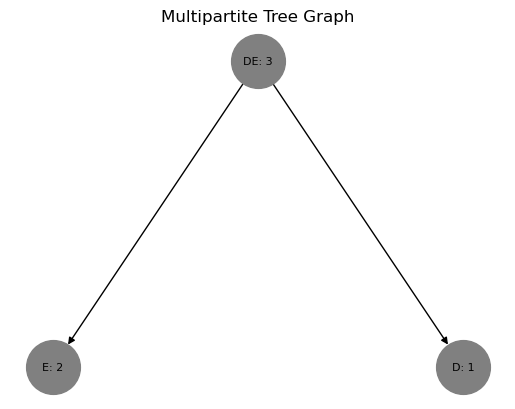

In [73]:
tree_dict = {
        1: {
            "D: 1":"DE: 3",
            "E: 2":"DE: 3"
            }
        }

# Create a NextworkX directed graph
g = nx.DiGraph()
g.add_nodes_from(['DE: 3'], subset=1)
g.add_nodes_from(tree_dict[1].keys(), subset=0)

# Add Title to Plot
plt.title('Multipartite Tree Graph')

# Create a list of the edges
edges = []
for subset_stuff in tree_dict.values():
    for node, prev_node in subset_stuff.items():
        edges.append((prev_node, node))

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1500, node_color='grey', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1500)
# Show the plot
plt.show()

### References

1. <a href="https://en.wikipedia.org/wiki/Huffman_coding">Wikipedia - Huffman`s coding</a>
2. <a href="https://en.wikipedia.org/wiki/Lossy_compression">Wikipedia - Lossy compression</a>
3. <a href="https://en.wikipedia.org/wiki/Lossless_compression">Wikipedia - Lossless compression</a>
4. <a href="https://www.khanacademy.org/computing/computers-and-internet/xcae6f4a7ff015e7d:digital-information/xcae6f4a7ff015e7d:data-compression/a/lossy-compression">Khanacademy - Lossy compression</a>
5. <a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)">Wikipedia - Entropy</a>
